# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#上述3行"%"只針對jupyter notebook，若有人編輯此程式自動重載，若要畫圖就直接在這裡呈現

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
#載入需要的library
#載入fastai.___指載入fastai library中的某個應用套件(這裡用vision及metrics)

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [37]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))


True
0
1
GeForce GTX 1080 Ti


## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [ ]:
#這次選用的題目是貓狗分辨的資料，這種類似圖分辨fine-grained classification

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [5]:
#下載及提取資料，調用"untar_data"來下載從AWS的資料庫，";"相當於換行，"path"就如同PYTHON中指的是print(path)
path = untar_data(URLs.PETS); path

WindowsPath('C:/Users/User/.fastai/data/oxford-iiit-pet')

In [6]:
#path裡有什麼
path.ls()

[WindowsPath('C:/Users/User/.fastai/data/oxford-iiit-pet/annotations'),
 WindowsPath('C:/Users/User/.fastai/data/oxford-iiit-pet/images')]

In [7]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [8]:
#在電腦視覺領域來說這種調用函數是很常見的，觀察這結果包含"名稱saint_bernard(標籤)""圖檔188(數字)"，這一優質的資料集要好好利用
#取前五的數據印出
fnames = get_image_files(path_img)
fnames[:5]

[WindowsPath('C:/Users/User/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 WindowsPath('C:/Users/User/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),
 WindowsPath('C:/Users/User/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),
 WindowsPath('C:/Users/User/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),
 WindowsPath('C:/Users/User/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg')]

In [9]:
#正則化
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [10]:
#正則化，調用GPU的運算過程input圖檔大小形狀均要相同，這樣才能加速運算速度及準確度
#ImageDataBunch是在fastai中放置資料的容器(資料束、資料集、資料清單)
#.from_name_re從名稱中"re"(regular expression)正則化提取"from_name_re"(圖片位置，檔案名，正則，圖片轉換，轉換的size要224，batch size
#                           ).normalize()
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

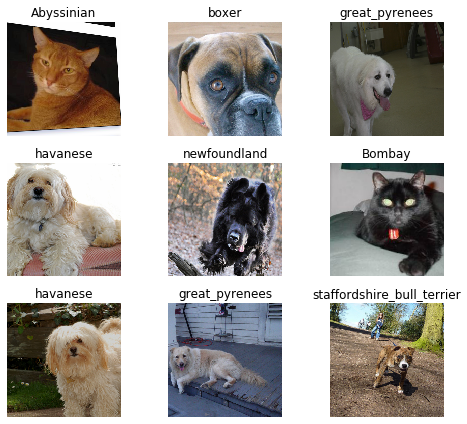

In [12]:
#呈現正則化的資料(通常我們希望物體在圖片中央/剪裁/縮放/充填等等)
data.show_batch(rows=3, figsize=(7,6))

In [13]:
#另外我們也同時關心資料的label是否正確，首先觀察資料種類"data.classes"清單是否合理正確，再來我們資料庫列出37種分類len(data.classes)來確認
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [14]:
#在fastai中調用model訓練的套件叫"learner"，而(cnn_learner或ConvLearner)convolutional neural network
#其中"cnn_learner"須包含(資料來源，所用之model為何?(resnet中又有兩種尺寸的演算法34及50))
#另外針對"metrics=error_rate"我們對於在訓練過程中錯誤率有興趣，請他將此訊息印出
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
#上述調用也將resnet34 pre-training 權重下載下來，這是一個很不錯的加快訓練方式(甚至是遷移學習也是)且針對訓練集較少的case也可取得不錯的效果，
#另外在驗證上我們會仰賴變異集(validation set)來做比較，變異集是不會參與訓練的獨立集metrics=error_rate就是根據變異集所的error而來
#而在上方data = ImageDataBunch.from_name_re...時就已經將資料自動分好了(fastai環境)，所以當learn = cnn_learner(data....就在此調用而來

In [15]:
#展開resnet34 model
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [18]:
help(learn.fit_one_cycle)

Help on method fit_one_cycle in module fastai.train:

fit_one_cycle(cyc_len:int, max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None), moms:Tuple[float, float]=(0.95, 0.85), div_factor:float=25.0, pct_start:float=0.3, final_div:float=None, wd:float=None, callbacks:Union[Collection[fastai.callback.Callback], NoneType]=None, tot_epochs:int=None, start_epoch:int=None) -> None method of fastai.basic_train.Learner instance
    Fit a model following the 1cycle policy.



In [16]:
#fit_one_cycle是作者(Jeremy Howard)研究，比較好的fit
#https://docs.fast.ai/callbacks.one_cycle.html
#https://sgugger.github.io/the-1cycle-policy.html
#https://arxiv.org/pdf/1803.09820.pdf
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.351371,0.331480,0.096752,02:56
1,0.551554,0.270713,0.090663,02:44
2,0.339375,0.230719,0.067659,02:45
3,0.268532,0.229063,0.069689,02:43


In [17]:
#存下剛剛訓練完的權重叫"stage-1"，而這其中來自不同的資料集(訓練、變異)就會將權重回存至各資料集中
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [19]:
#以上用完input現在來看output，interp就是Interpretation(解釋)就是learn模型結果
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

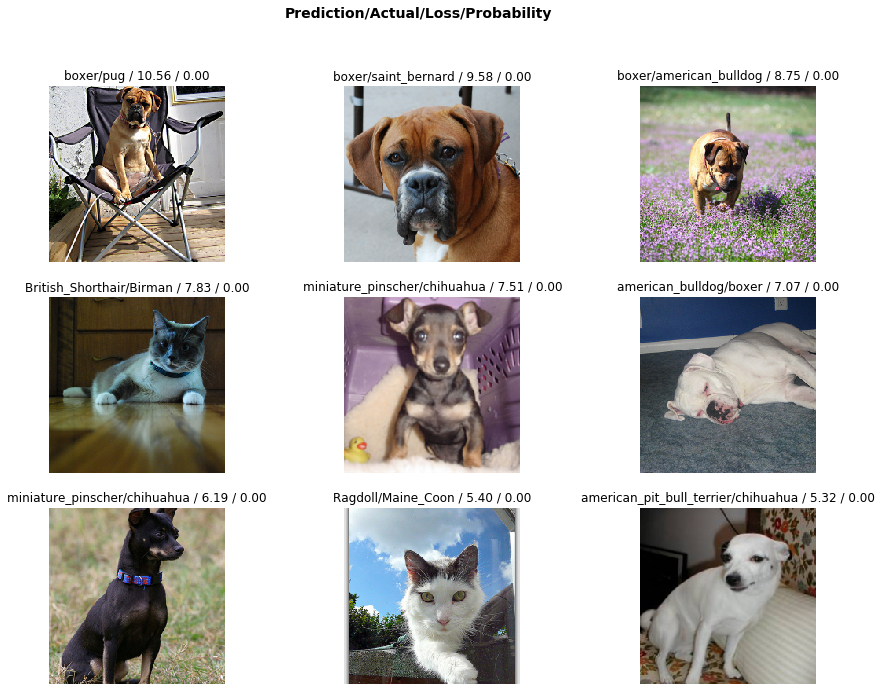

In [20]:
#接著我們來觀察結果，首先".plot_top_losses(9, figsize=(15,11))"我們看模型結果中top losses(最差)前9名
#我最有信心預測錯誤的前9名
interp.plot_top_losses(9, figsize=(15,11))

In [21]:
#有關"interp.plot_top_losses"詳細文件
doc(interp.plot_top_losses)

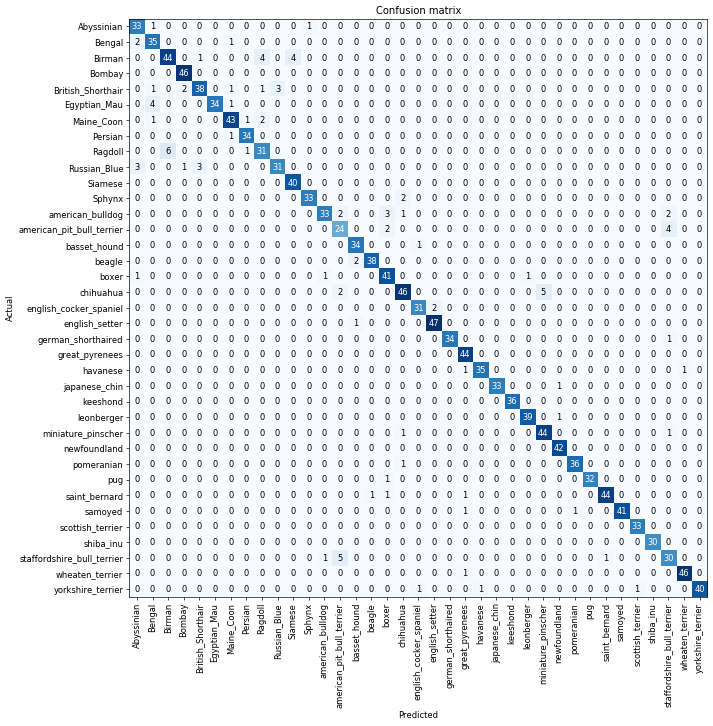

In [22]:
#畫出各貓狗品種列表混淆矩陣，對角線上深色代表預測正確，其餘5、3、2等預測錯誤
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
#直接列出混淆項(至少2以上)
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 6),
 ('chihuahua', 'miniature_pinscher', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Birman', 'Ragdoll', 4),
 ('Birman', 'Siamese', 4),
 ('Egyptian_Mau', 'Bengal', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Russian_Blue', 'Abyssinian', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('american_bulldog', 'boxer', 3),
 ('Bengal', 'Abyssinian', 2),
 ('British_Shorthair', 'Bombay', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Sphynx', 'chihuahua', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('american_pit_bull_terrier', 'boxer', 2),
 ('beagle', 'basset_hound', 2),
 ('chihuahua', 'american_pit_bull_terrier', 2),
 ('english_cocker_spaniel', 'english_setter', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [24]:
#上述用的方式為取用權重且屬於fine-tuning所以很快，這裡調用.unfreeze重頭訓練
learn.unfreeze()

In [25]:
#訓練結果不盡理想，誤差很大11.77%
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.549293,0.355955,0.117727,02:47


In [26]:
#將fine-tuning後權重檔案load回來
learn.load('stage-1');

In [27]:
#使用fastai內建的lr_find，learning rate finder
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


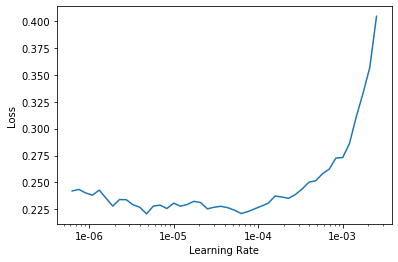

In [28]:
learn.recorder.plot()

In [29]:
#這裡調用.unfreeze重頭訓練
#learn.fit_one_cycle(2"兩次", max_lr=slice(1e-6,1e-4)"slice預設0.003，slice(切片)從第一層的1e-6到最後一層的1e-4一系列的learning rate分配給各層")
#取這段的learning rate主要是要"未"變差(loss變大)前的區段
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.216725,0.216868,0.068336,02:45
1,0.212085,0.212403,0.065629,02:46


In [ ]:
#line16 6.9689% V.S. line29 6.5629%

That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [30]:
#resnet50比resnet34參數大得多，在有限的gpu、ram的資源下batch size(bs)太大會導致運算中途資源會被吃完而無法運作下去，所以在這batch size需要減少
#batch size，用bs=bs//2來縮小不過這會讓運算變慢...
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [31]:
#下載resnet50 pre-training權重
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\User/.torch\models\resnet50-19c8e357.pth
100%|██████████████████████████████████████████████████████████████| 102502400/102502400 [00:08<00:00, 12220916.31it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


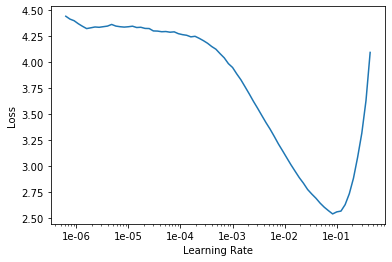

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.739269,0.318933,0.094046,03:19
1,0.407556,0.266806,0.087957,03:17
2,0.343477,0.220360,0.073748,03:16
3,0.260837,0.228260,0.074425,03:16
4,0.205743,0.240009,0.073072,03:17
5,0.144564,0.204660,0.066306,03:15
6,0.099395,0.193999,0.059540,03:17
7,0.104834,0.195102,0.057510,03:18


In [34]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [38]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.089680,0.201805,0.060217,03:44
1,0.095579,0.202167,0.060893,03:41
2,0.075901,0.189672,0.056157,03:41


If it doesn't, you can always go back to your previous model.

In [39]:
learn.load('stage-1-50');

In [ ]:
#line33 5.751% V.S. line38 5.6157%

In [40]:
interp = ClassificationInterpretation.from_learner(learn)

In [41]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Ragdoll', 'Birman', 4),
 ('american_bulldog', 'staffordshire_bull_terrier', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('boxer', 'american_bulldog', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('Abyssinian', 'Sphynx', 2),
 ('Bengal', 'Egyptian_Mau', 2),
 ('Birman', 'Siamese', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Ragdoll', 'Persian', 2),
 ('Siamese', 'Birman', 2),
 ('american_bulldog', 'boxer', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_cocker_spaniel', 'havanese', 2),
 ('miniature_pinscher', 'american_pit_bull_terrier', 2)]

## Other data formats

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

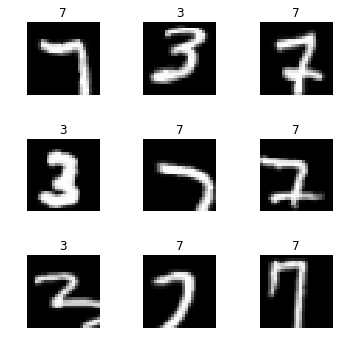

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

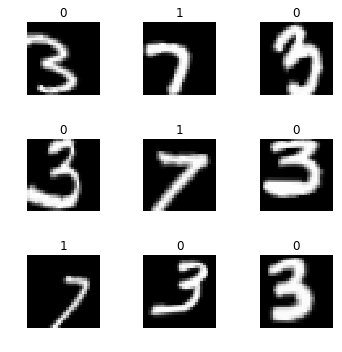

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [ ]:
doc(ImageDataBunch.from_name_re)

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']